In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima



import joblib
import json
import pandas as pd
import numpy as np
import copy
import hashlib

import src.util as util

## 1. Load Configuration File

In [3]:
params = util.load_config()

## 2. Load Dataset

In [4]:
def load_train_feng(params: dict) -> pd.DataFrame:
    # Load train set
    x_train = util.pickle_load(params["train_set_path"][0])
    y_train = util.pickle_load(params["train_set_path"][1])

    return x_train, y_train

def load_valid_feng(params: dict) -> pd.DataFrame:
    # Load valid set
    x_valid = util.pickle_load(params["valid_set_path"][0])
    y_valid = util.pickle_load(params["valid_set_path"][1])

    return x_valid, y_valid

def load_test_feng(params: dict) -> pd.DataFrame:
    # Load test set
    x_test = util.pickle_load(params["test_set_path"][0])
    y_test = util.pickle_load(params["test_set_path"][1])

    return x_test, y_test

In [5]:
def load_dataset(params: dict) -> pd.DataFrame:
    # Debug message
    util.print_debug("Loading dataset.")

    # Load train set
    x_train, y_train = load_train_feng(params)

    # Load valid set
    x_valid, y_valid = load_valid_feng(params)

    # Load test set
    x_test, y_test = load_test_feng(params)

    # Debug message
    util.print_debug("Dataset loaded.")

    # Return the dataset
    return x_train, y_train, x_valid, y_valid, x_test, y_test

In [6]:
def training_log_template() -> dict:
    # Debug message
    util.print_debug("Creating training log template.")
    
    # Template of training log
    logger = {
        "model_name" : [],
        "model_uid" : [],
        "training_time" : [],
        "training_date" : [],
        "mse" : [],
        "mae" : []
    }

    # Debug message
    util.print_debug("Training log template created.")

    # Return training log template
    return logger

In [7]:
def training_log_updater(current_log: dict, params: dict) -> list:
    # Create copy of current log
    current_log = copy.deepcopy(current_log)

    # Path for training log file
    log_path = params["training_log_path"]

    # Try to load training log file
    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()

    # If file not found, create a new one
    except FileNotFoundError as fe:
        with open(log_path, "w") as file:
            file.write("[]")
        file.close()

        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    
    # Add current log to previous log
    last_log.append(current_log)

    # Save updated log
    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    # Return log
    return last_log

### X.1 Create Model Object

In [8]:
def create_model_object(params: dict, endog, exog) -> list:
    
    # Debug message
    util.print_debug("Creating model objects.")

    # Create model objects
    model = auto_arima(
        y=endog,
        X=exog,
        seasonal=True,
        m=2,
        trace=True,
        stepwise=True,
        suppress_warnings=True,
    )
    srm = SARIMAX(endog=endog, exog=exog, order=model.order, seasonal_order=model.seasonal_order, enforce_stationarity=False,
    enforce_invertibility=False)


    # Create list of model
    list_of_model = [
        { "model_name": srm.__class__.__name__, "model_object": srm, "model_uid": ""}
    ]

    # Debug message
    util.print_debug("Model objects created.")

    # Return the list of model
    return list_of_model

In [9]:
def train_eval(configuration_model: str, params: dict, hyperparams_model: list = None):
    #load dataset
    X_train, y_train, \
    X_valid, y_valid, \
    X_test, y_test = load_dataset(params)

    #variable to store trained model
    list_of_trained_model = dict()

    #creata log template
    training_log = training_log_template()
    features_data = X_train.columns

    #Debug message
    util.print_debug("Training model based on following features: {}".format(features_data))
    
    #Create model objects
    if hyperparams_model == None:
        list_of_model = create_model_object(params=params, endog=y_train, exog=X_train)
    else:
        list_of_model = copy.deepcopy(hyperparams_model)

    #variable to store trained model
    trained_model = list()

    for model in list_of_model:
        # Debug Message
        util.print_debug('Training model: {}'.format(model['model_name']))

        #training
        training_time = util.time_stamp()
        model_result = model['model_object'].fit(maxiter=200)
        training_time = (util.time_stamp() - training_time).total_seconds()

        # Debug message
        util.print_debug("Evaluating model name: {}".format(model["model_name"]))
        util.print_debug("Evaluating model object: {}".format(model["model_object"]))

        #Evaluation
        y_predict = model_result.predict(exog= X_valid, start=0, end=len(X_valid) - 1)
        mae = mean_absolute_error(y_valid, y_predict)
        mse = mean_squared_error(y_valid, y_predict)
        rmse = np.sqrt(mse)

        performance = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
        }

        #Debug Message
        util.print_debug('Logging: {}'.format(model['model_name']))

        # Create UID
        uid = hashlib.md5(str(training_time).encode()).hexdigest()

        # Assign model's UID
        model['model_uid'] = uid

        # Create training log data
        training_log["model_name"].append("{}-{}".format(configuration_model, model["model_name"]))
        training_log["model_uid"].append(uid)
        training_log["training_time"].append(training_time)
        training_log["training_date"].append(util.time_stamp())
        training_log["mse"].append(performance['MSE'])
        training_log["mae"].append(performance['MAE'])

        # Collect current trained model
        trained_model.append(copy.deepcopy(model))

        # Debug message
        util.print_debug("Model {} has been trained.".format(model["model_name"]))
    
    # Collect current trained list of model
    list_of_trained_model = copy.deepcopy(trained_model)

    # Debug message
    util.print_debug("All combination models has been trained.")

    # Return list trained model
    return list_of_trained_model, training_log, model_result


In [10]:
list_of_trained_model, training_log, model_result = train_eval("Baseline", params)

2023-05-04 15:52:46.964263 Loading dataset.
2023-05-04 15:52:46.968030 Dataset loaded.
2023-05-04 15:52:46.968043 Creating training log template.
2023-05-04 15:52:46.968046 Training log template created.
2023-05-04 15:52:46.968515 Training model based on following features: Index(['APII.JK', 'IKBI.JK', 'INTD.JK', 'JKON.JK', 'KICI.JK', 'PDES.JK',
       'PGJO.JK', 'TLKM.JK', 'ULTJ.JK'],
      dtype='object')
2023-05-04 15:52:46.968524 Creating model objects.
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=-1345.119, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=-1347.810, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=-1349.142, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=-1348.888, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=-1348.075, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=-1346.996, Time=0.16 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=-1347.168, Time=0.26 sec
 ARIMA(1,0,0)(1,0,1)[2] in

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     56     80      1     0     0   1.440D-03  -2.648D+00
  F =  -2.6482978119958482     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2023-05-04 15:52:50.034618 Evaluating model name: SARIMAX
2023-05-04 15:52:50.034629 Evaluating model object: <statsmodels.tsa.statespace.sarimax.SARIMAX object at 0x12f95b810>
2023-05-04 15:52:50.035728 Logging: SARIMAX
2023-05-04 15:52:50.036709 Model SARIMAX has been trained.
2023-05-04 15:52:50.037542 All combination models has been trained.



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [11]:
list_of_trained_model

[{'model_name': 'SARIMAX',
  'model_object': <statsmodels.tsa.statespace.sarimax.SARIMAX at 0x17f81ded0>,
  'model_uid': 'cff39091ef15fb304fb02fb60e21a729'}]

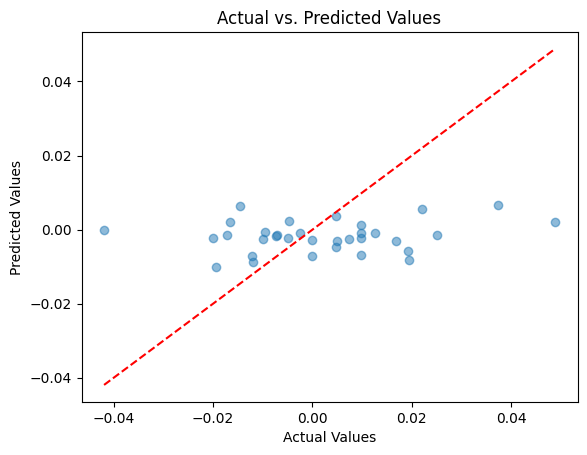

In [12]:
import matplotlib.pyplot as plt

X_test, y_test = load_test_feng(params)

y_pred = model_result.predict(exog= X_test, start=0, end=len(X_test) - 1)
y_pred.index = X_test.index
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line representing a perfect prediction
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.show()

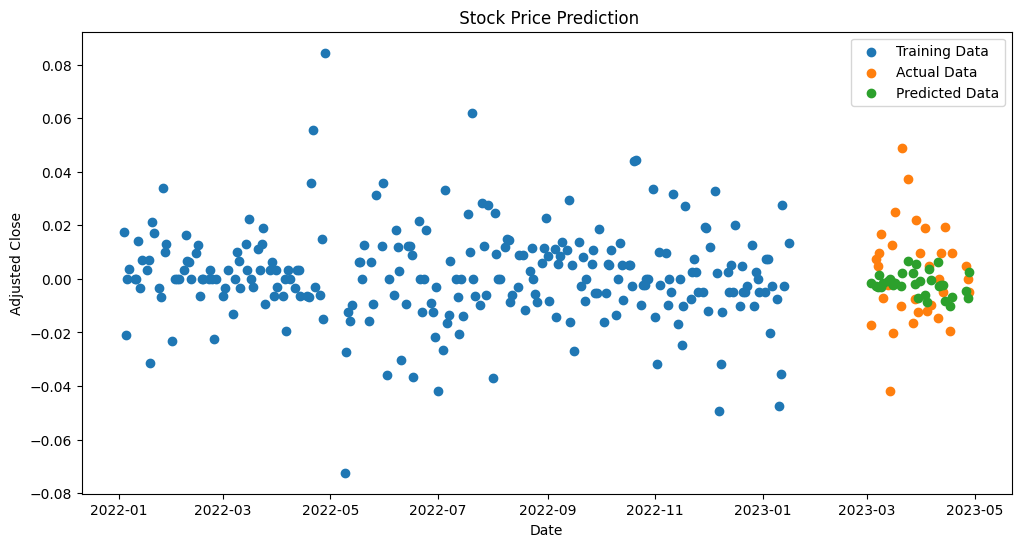

In [13]:
import seaborn as sns

X_train, y_train = load_train_feng(params)

plt.figure(figsize=(12, 6))
plt.scatter(X_train.index, y_train, label="Training Data")
plt.scatter(X_test.index, y_test, label="Actual Data")
plt.scatter(X_test.index, y_pred, label="Predicted Data")
plt.xlabel("Date")
plt.ylabel("Adjusted Close")
plt.title(f" Stock Price Prediction")
plt.legend()
plt.show()

In [14]:
display(y_pred.index)
display(X_test.index)

DatetimeIndex(['2023-03-03', '2023-03-06', '2023-03-07', '2023-03-08',
               '2023-03-09', '2023-03-10', '2023-03-13', '2023-03-14',
               '2023-03-15', '2023-03-16', '2023-03-17', '2023-03-20',
               '2023-03-21', '2023-03-24', '2023-03-27', '2023-03-28',
               '2023-03-29', '2023-03-30', '2023-03-31', '2023-04-03',
               '2023-04-04', '2023-04-05', '2023-04-06', '2023-04-10',
               '2023-04-11', '2023-04-12', '2023-04-13', '2023-04-14',
               '2023-04-17', '2023-04-18', '2023-04-26', '2023-04-27',
               '2023-04-28'],
              dtype='datetime64[ns]', name='Date', freq=None)

DatetimeIndex(['2023-03-03', '2023-03-06', '2023-03-07', '2023-03-08',
               '2023-03-09', '2023-03-10', '2023-03-13', '2023-03-14',
               '2023-03-15', '2023-03-16', '2023-03-17', '2023-03-20',
               '2023-03-21', '2023-03-24', '2023-03-27', '2023-03-28',
               '2023-03-29', '2023-03-30', '2023-03-31', '2023-04-03',
               '2023-04-04', '2023-04-05', '2023-04-06', '2023-04-10',
               '2023-04-11', '2023-04-12', '2023-04-13', '2023-04-14',
               '2023-04-17', '2023-04-18', '2023-04-26', '2023-04-27',
               '2023-04-28'],
              dtype='datetime64[ns]', name='Date', freq=None)

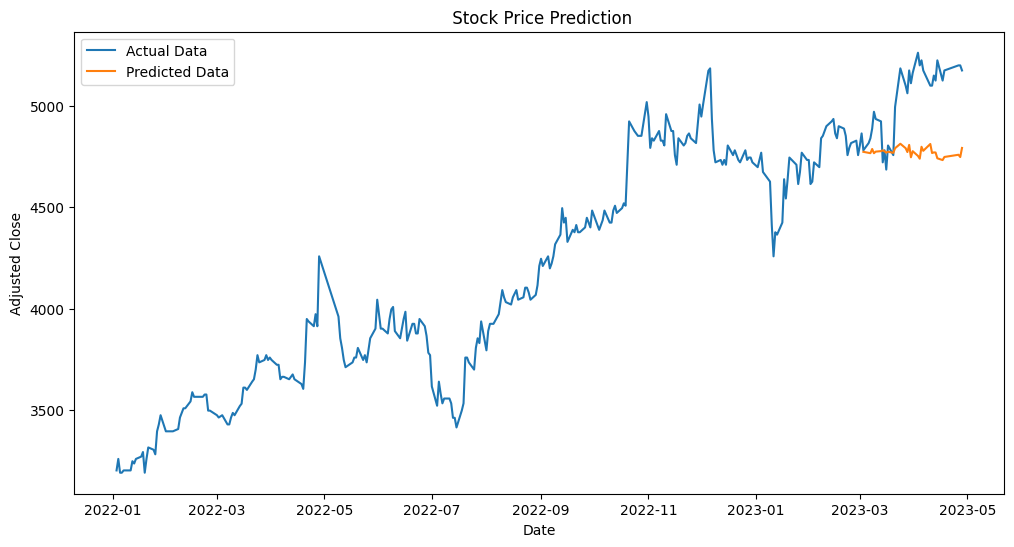

In [15]:
actual_price = util.pickle_load(params["raw_dataset_path"])[params['target_stock']]
prediction_log = np.log(actual_price[y_pred.index[0]]) + y_pred
prediction_prices = np.exp(prediction_log)

plt.figure(figsize=(12, 6))
plt.plot(actual_price.index, actual_price, label="Actual Data")
plt.plot(prediction_prices.index, prediction_prices, label="Predicted Data")
plt.xlabel("Date")
plt.ylabel("Adjusted Close")
plt.title(f" Stock Price Prediction")
plt.legend()
plt.show()

In [16]:
util.pickle_dump(prediction_prices, params["predict_dataset_path"])



In [26]:
from vega_datasets import data

source = data.stocks()
source

,symbol,date,price
0,MSFT,2000-01-01,39.81
1,MSFT,2000-02-01,36.35
2,MSFT,2000-03-01,43.22
3,MSFT,2000-04-01,28.37
4,MSFT,2000-05-01,25.45
...,...,...,...
555,AAPL,2009-11-01,199.91
556,AAPL,2009-12-01,210.73
557,AAPL,2010-01-01,192.06
558,AAPL,2010-02-01,204.62


In [44]:
actual_price = pd.DataFrame(util.pickle_load(params["raw_dataset_path"])[params['target_stock']])
predict_price = pd.DataFrame(util.pickle_load(params["predict_dataset_path"]))

actual_price['symbol'] = params["target_stock"]
predict_price['symbol'] = params["target_stock"]
predict_price['predicted_mean'].columns = params['target_stock']
predict_price.rename(columns={predict_price.columns[0]: 'price'}, inplace=True)
actual_price.rename(columns={actual_price.columns[0]: 'price'}, inplace=True)


In [45]:
display(actual_price)
display(predict_price)

,price,symbol
Date,,
2022-01-03,3201.196533,BMRI.JK
2022-01-04,3257.955322,BMRI.JK
2022-01-05,3189.844727,BMRI.JK
2022-01-06,3189.844727,BMRI.JK
2022-01-07,3201.196533,BMRI.JK
...,...,...
2023-04-17,5125.000000,BMRI.JK
2023-04-18,5175.000000,BMRI.JK
2023-04-26,5200.000000,BMRI.JK


,price,symbol
Date,,
2023-03-03,4773.428577,BMRI.JK
2023-03-06,4768.376235,BMRI.JK
2023-03-07,4766.779082,BMRI.JK
2023-03-08,4787.364893,BMRI.JK
2023-03-09,4766.627511,BMRI.JK
2023-03-10,4774.419469,BMRI.JK
2023-03-13,4776.825340,BMRI.JK
2023-03-14,4780.841331,BMRI.JK
2023-03-15,4775.996198,BMRI.JK


In [64]:
actual_price = pd.DataFrame(util.pickle_load(params["raw_dataset_path"])[params['target_stock']])
predict_price = pd.DataFrame(util.pickle_load(params["predict_dataset_path"]))

actual_price['symbol'] = params["target_stock"] + ' Actual'
predict_price['symbol'] = params["target_stock"] + ' Prediction'
predict_price['predicted_mean'].columns = params['target_stock']
predict_price.rename(columns={predict_price.columns[0]: 'price'}, inplace=True)
actual_price.rename(columns={actual_price.columns[0]: 'price'}, inplace=True)

stock_price = pd.concat([actual_price, predict_price], axis=0)

In [65]:
stock_price

,price,symbol
Date,,
2022-01-03,3201.196533,BMRI.JK Actual
2022-01-04,3257.955322,BMRI.JK Actual
2022-01-05,3189.844727,BMRI.JK Actual
2022-01-06,3189.844727,BMRI.JK Actual
2022-01-07,3201.196533,BMRI.JK Actual
...,...,...
2023-04-17,4732.696926,BMRI.JK Prediction
2023-04-18,4748.091617,BMRI.JK Prediction
2023-04-26,4758.944019,BMRI.JK Prediction


In [66]:
stock_price.index.name = 'date'
stock_price.reset_index(inplace=True)

In [67]:
source.dtypes

symbol            object
date      datetime64[ns]
price            float64
dtype: object

In [68]:
stock_price.dtypes

date      datetime64[ns]
price            float64
symbol            object
dtype: object

In [69]:
latest_price = stock_price[stock_price['symbol'] == params["target_stock"] + ' Actual'].sort_values(by='date', ascending=False).iloc[0]['price']


In [70]:
latest_price

5175.0